In [27]:
import sys
import os
import numpy as np
import pandas as pd

# need to be able to import src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# absolute path to the src directory
src_path = os.path.abspath("../src")

# Add src directory to system path
sys.path.append(src_path)

# get the /MLCBAss1/Assignment-1 path
ass_path=sys.path[-2]

print(ass_path)


%load_ext autoreload
%autoreload 2

from functions import *

/home/sdi1700187/MLCBAss1/Assignment-1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# we load the two datasets
dev_set_df=pd.read_csv("../data/development_final_data.csv")
val_set_df=pd.read_csv("../data/evaluation_final_data.csv")

dev_set_df=dev_set_df.drop(labels=['Unnamed: 0'],axis=1)
val_set_df=val_set_df.drop(labels=['Unnamed: 0'],axis=1)

dev_set_df.head()
# val_set_df.head()
bacteria=get_bacteria(dev_set_df,mode='analysis')
bacteria_names=bacteria.columns
y_train=dev_set_df["BMI"]
x_train=scale_data(bacteria,bacteria_names)

bacteria_val=get_bacteria(val_set_df,mode='analysis')
bacteria_names_val=bacteria_val.columns
y_val=val_set_df["BMI"]
x_val=scale_data(bacteria_val,bacteria_names_val)


In [29]:
models_dir="../models"

model_io=IO(models_dir)

baseline_predictor=DefaultPredictor()

In [30]:
# Baseline models

# train models
baseline_models=baseline_predictor.train_models(x_train=x_train,y_train=y_train)

# save models
for name,model in baseline_models.items():
    model_io.save(model,name,suf='bsln')

In [31]:
# we evaluate the baseline models

# Elastic Net
baseline_elastic_evaluator=Evaluator(model=model_io.load('ElasticNet',suf='bsln'),name='ElasticNet')
baseline_elastic_evaluator.evaluate(x=x_val,y=y_val)

baseline_elastic_report=baseline_elastic_evaluator.report()
baseline_elastic_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,3.8794,0.3304,3.8691,3.2593,4.5849
MAE,2.7381,0.1847,2.7382,2.3567,3.1039
R2,0.0395,0.0163,0.0405,0.0044,0.0728


In [32]:
# SVR
baseline_svr_evaluator=Evaluator(model=model_io.load('SVR',suf='bsln'),name='SVR')
baseline_svr_evaluator.evaluate(x=x_val,y=y_val)

baseline_svr_report=baseline_svr_evaluator.report()
baseline_svr_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,3.6928,0.3500,3.6887,3.0190,4.4536
MAE,2.3473,0.1905,2.3484,1.9711,2.7253
R2,0.1307,0.0326,0.1302,0.0687,0.1958


In [33]:
# Bayesian Ridge
baseline_bayesian_evaluator=Evaluator(model=model_io.load('BayesianRidge',suf='bsln'),name='BayesianRidge')
baseline_bayesian_evaluator.evaluate(x=x_val,y=y_val)

baseline_bayesian_report=baseline_bayesian_evaluator.report()
baseline_bayesian_report.head()

,mean,std,median,CIlow,CIhigh
RMSE,3.8478,0.3172,3.8340,3.2567,4.5220
MAE,2.6702,0.1870,2.6640,2.3116,3.0266
R2,0.0537,0.0459,0.0565,-0.0434,0.1396


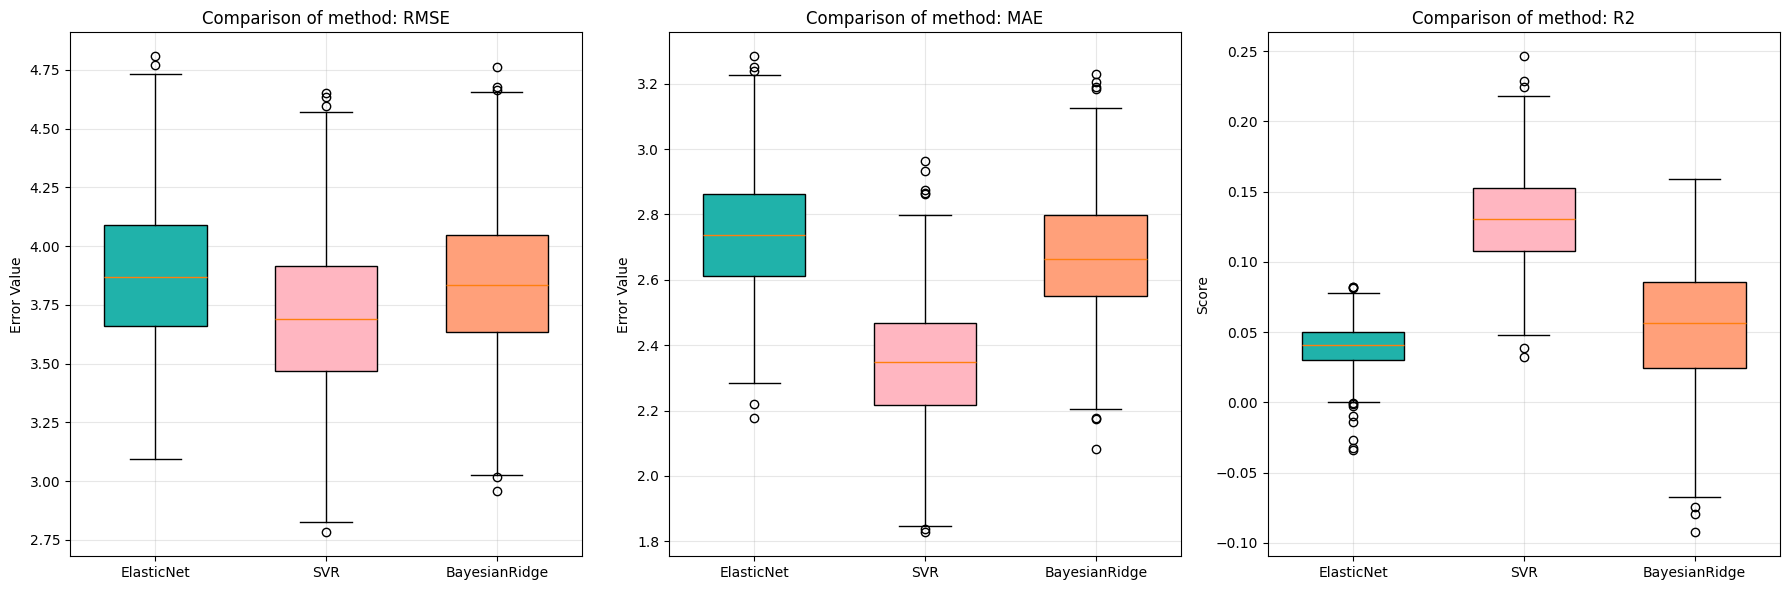

In [34]:
# we visualize the comparison between the methods
viz_comparison(baseline_elastic_evaluator,baseline_svr_evaluator,baseline_bayesian_evaluator)